<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предварительная-обработка" data-toc-modified-id="Предварительная-обработка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предварительная обработка</a></span><ul class="toc-item"><li><span><a href="#Первичное-знакомство-с-данными" data-toc-modified-id="Первичное-знакомство-с-данными-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Первичное знакомство с данными</a></span></li><li><span><a href="#Изменение-типа-данных" data-toc-modified-id="Изменение-типа-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Изменение типа данных</a></span></li><li><span><a href="#Обработка-пропущенных-значений" data-toc-modified-id="Обработка-пропущенных-значений-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Обработка пропущенных значений</a></span><ul class="toc-item"><li><span><a href="#сategory_list" data-toc-modified-id="сategory_list-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span><code>сategory_list</code></a></span></li><li><span><a href="#funding_total_usd" data-toc-modified-id="funding_total_usd-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span><code>funding_total_usd</code></a></span></li><li><span><a href="#country_code,-state_code,-region,-city" data-toc-modified-id="country_code,-state_code,-region,-city-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span><code>country_code</code>, <code>state_code</code>, <code>region</code>, <code>city</code></a></span></li><li><span><a href="#first_funding_at" data-toc-modified-id="first_funding_at-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span><code>first_funding_at</code></a></span></li><li><span><a href="#closed_at" data-toc-modified-id="closed_at-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span><code>closed_at</code></a></span></li></ul></li><li><span><a href="#Обработка-неявных-дубликатов" data-toc-modified-id="Обработка-неявных-дубликатов-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обработка неявных дубликатов</a></span></li></ul></li></ul></div>

# Проект "Стартапы"

В рамках проекта предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1980 по 2018 годы, и предсказать, какие из них закроются.

# Постановка задачи

Построить прогнозную модель, которая предскажет будущее этих компаний, и определить, продолжат ли они свою деятельность в будущем. Для решения задачи будут выполнены следующие шаги:
- загрузка и ознакомление с данными;
- предварительная обработка;
- исследовательский анализ;
- разработка новых синтетических признаков;
- проверка на мультиколлинеарность;
- отбор финального набора обучающих признаков;
- выбор и обучение моделейд
- итоговая оценка качества предсказания лучшей модели;
- анализ важности ее признаков;
- подготовка отчета по исследованию.

In [1]:
pip install missingno -q


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install fuzzywuzzy -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install python-Levenshtein -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Загрузка необходимых библиотек
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

from fuzzywuzzy import fuzz
from fuzzywuzzy import process


In [5]:
# Инициализация констант
PATH = "D:/Projects/datasets/startups_predictions"

## Загрузка данных

Скачаем датасеты train и test в локальную директорию `PATH`, далее загрузим указанные датасеты:

In [6]:
# Функция для чтения csv-файла в датафрейм, вывод основной информаии о датафрейме на экран.
# В качестве результата возвращает датафрейм
# Разделитель - ','. Десятичный разделитель - '.'
def read_and_display(path):
    
    df = pd.read_csv(path)
    display(df.head(5))
    df.info()
    
    return df


# Чтение сsv-файлов
df_train = read_and_display(PATH+'/kaggle_startups_train_01.csv')
df_test = read_and_display(PATH+'/kaggle_startups_test_01.csv')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52878 non-null  object 
 1   category_list      50374 non-null  object 
 2   funding_total_usd  42753 non-null  float64
 3   status             52879 non-null  object 
 4   country_code       47351 non-null  object 
 5   state_code         46082 non-null  object 
 6   region             46489 non-null  object 
 7   city               46489 non-null  object 
 8   funding_rounds     52879 non-null  int64  
 9   founded_at         52879 non-null  object 
 10  first_funding_at   52858 non-null  object 
 11  last_funding_at    52879 non-null  object 
 12  closed_at          4962 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,NaN
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,NaN
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,NaN
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,NaN
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13211 non-null  object 
 1   category_list      12610 non-null  object 
 2   funding_total_usd  10616 non-null  float64
 3   country_code       11827 non-null  object 
 4   state_code         11512 non-null  object 
 5   region             11618 non-null  object 
 6   city               11620 non-null  object 
 7   funding_rounds     13211 non-null  int64  
 8   founded_at         13211 non-null  object 
 9   first_funding_at   13211 non-null  object 
 10  last_funding_at    13211 non-null  object 
 11  closed_at          1234 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.2+ MB


**Выводы:**

Были успешно созданы 2 датафрейма `df_test` и `df_train` на основе исходных csv-файлов. Все указанные поля из описания задачи присутствуют в соответствующих датафреймах. Информация в столбцах совпадает с описанием признака.

## Предварительная обработка

### Первичное знакомство с данными

Подготовим функцию для первичного знакомства с данными:

In [7]:
# функция для первичного знакомства с данными
# name - наименование датафрейма
# df - датафрейм
def data_first_look(name, df):
    print('\nДатафрейм:',name)
    print('Типы данных:\n', df.dtypes)
    print('Количество явных дубликатов датафрейма:', df.duplicated().sum())
    print('Количество пропущенных значений:',df.isna().sum().sum())

Выполним функцию для ранее созданных датафреймов:

In [8]:
# разместим датафреймы в словарь
dataframes = {
    'train': df_train,
    'test': df_test
}
# вызов функции первичного знакомства с данными для каждого датафрейма
for name, df in dataframes.items():
    data_first_look(name, df)


Датафрейм: train
Типы данных:
 name                  object
category_list         object
funding_total_usd    float64
status                object
country_code          object
state_code            object
region                object
city                  object
funding_rounds         int64
founded_at            object
first_funding_at      object
last_funding_at       object
closed_at             object
dtype: object
Количество явных дубликатов датафрейма: 0
Количество пропущенных значений: 85675

Датафрейм: test
Типы данных:
 name                  object
category_list         object
funding_total_usd    float64
country_code          object
state_code            object
region                object
city                  object
funding_rounds         int64
founded_at            object
first_funding_at      object
last_funding_at       object
closed_at             object
dtype: object
Количество явных дубликатов датафрейма: 0
Количество пропущенных значений: 21440


**Выводы:**

Первичное знакомство с данными выявило 2 явных проблемы:
- тип данных для дат;
- наличие большого количества пропущенных значений.

### Изменение типа данных

Изменим тип данных для столбцов, содержащих дату:

In [9]:
cols = ['founded_at','first_funding_at', 'last_funding_at', 'closed_at']
for name, df in dataframes.items():
    df[cols] = df[cols].apply(pd.to_datetime)
    print('Типы данных:\n', df.dtypes)

Типы данных:
 name                         object
category_list                object
funding_total_usd           float64
status                       object
country_code                 object
state_code                   object
region                       object
city                         object
funding_rounds                int64
founded_at           datetime64[ns]
first_funding_at     datetime64[ns]
last_funding_at      datetime64[ns]
closed_at            datetime64[ns]
dtype: object
Типы данных:
 name                         object
category_list                object
funding_total_usd           float64
country_code                 object
state_code                   object
region                       object
city                         object
funding_rounds                int64
founded_at           datetime64[ns]
first_funding_at     datetime64[ns]
last_funding_at      datetime64[ns]
closed_at            datetime64[ns]
dtype: object


**Выводы:**

Тип данных был успешно изменен на `datetime` для следующих столбцов в обоих датафреймах:
- `founded_at`;
- `first_funding_at`;
- `last_funding_at`;
- `closed_at`.

### Обработка пропущенных значений

Посмотрим на пропуски более детально:


Датафрейм: train


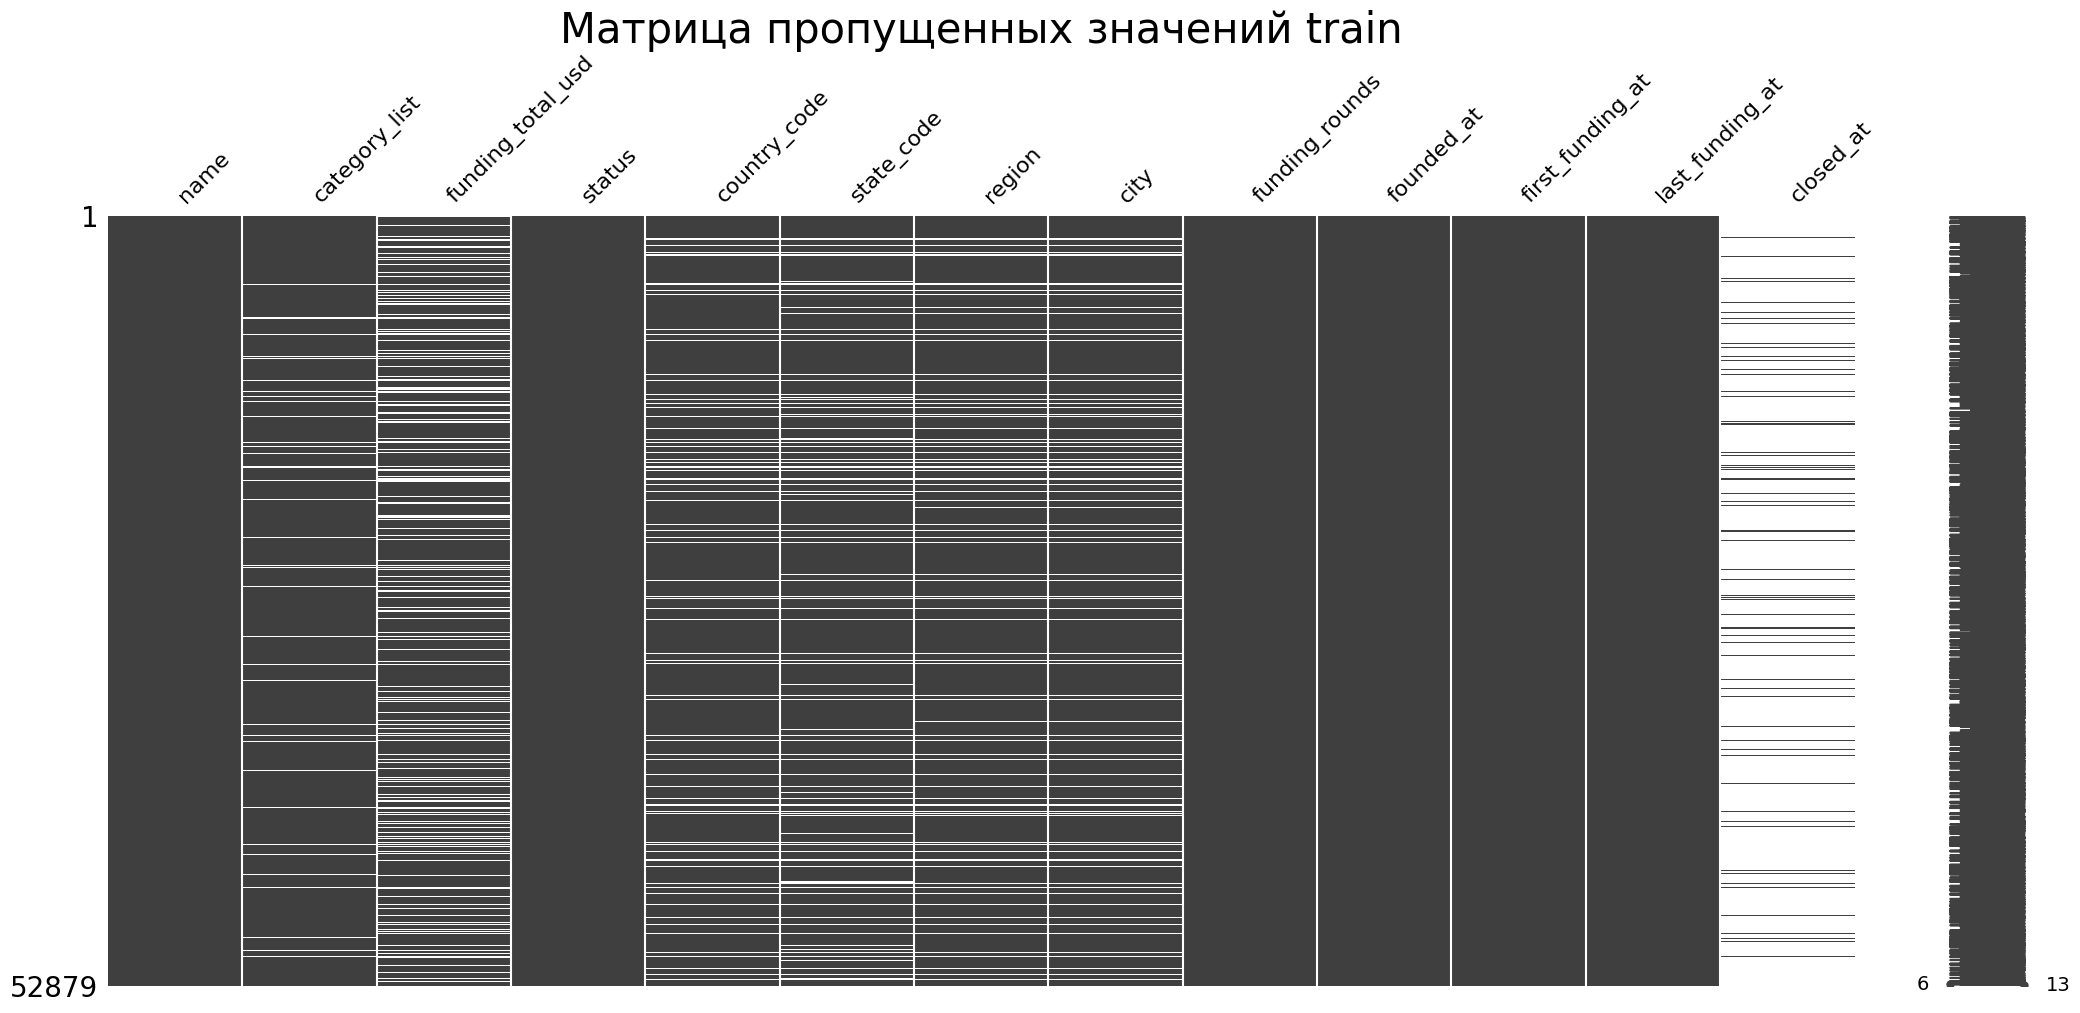

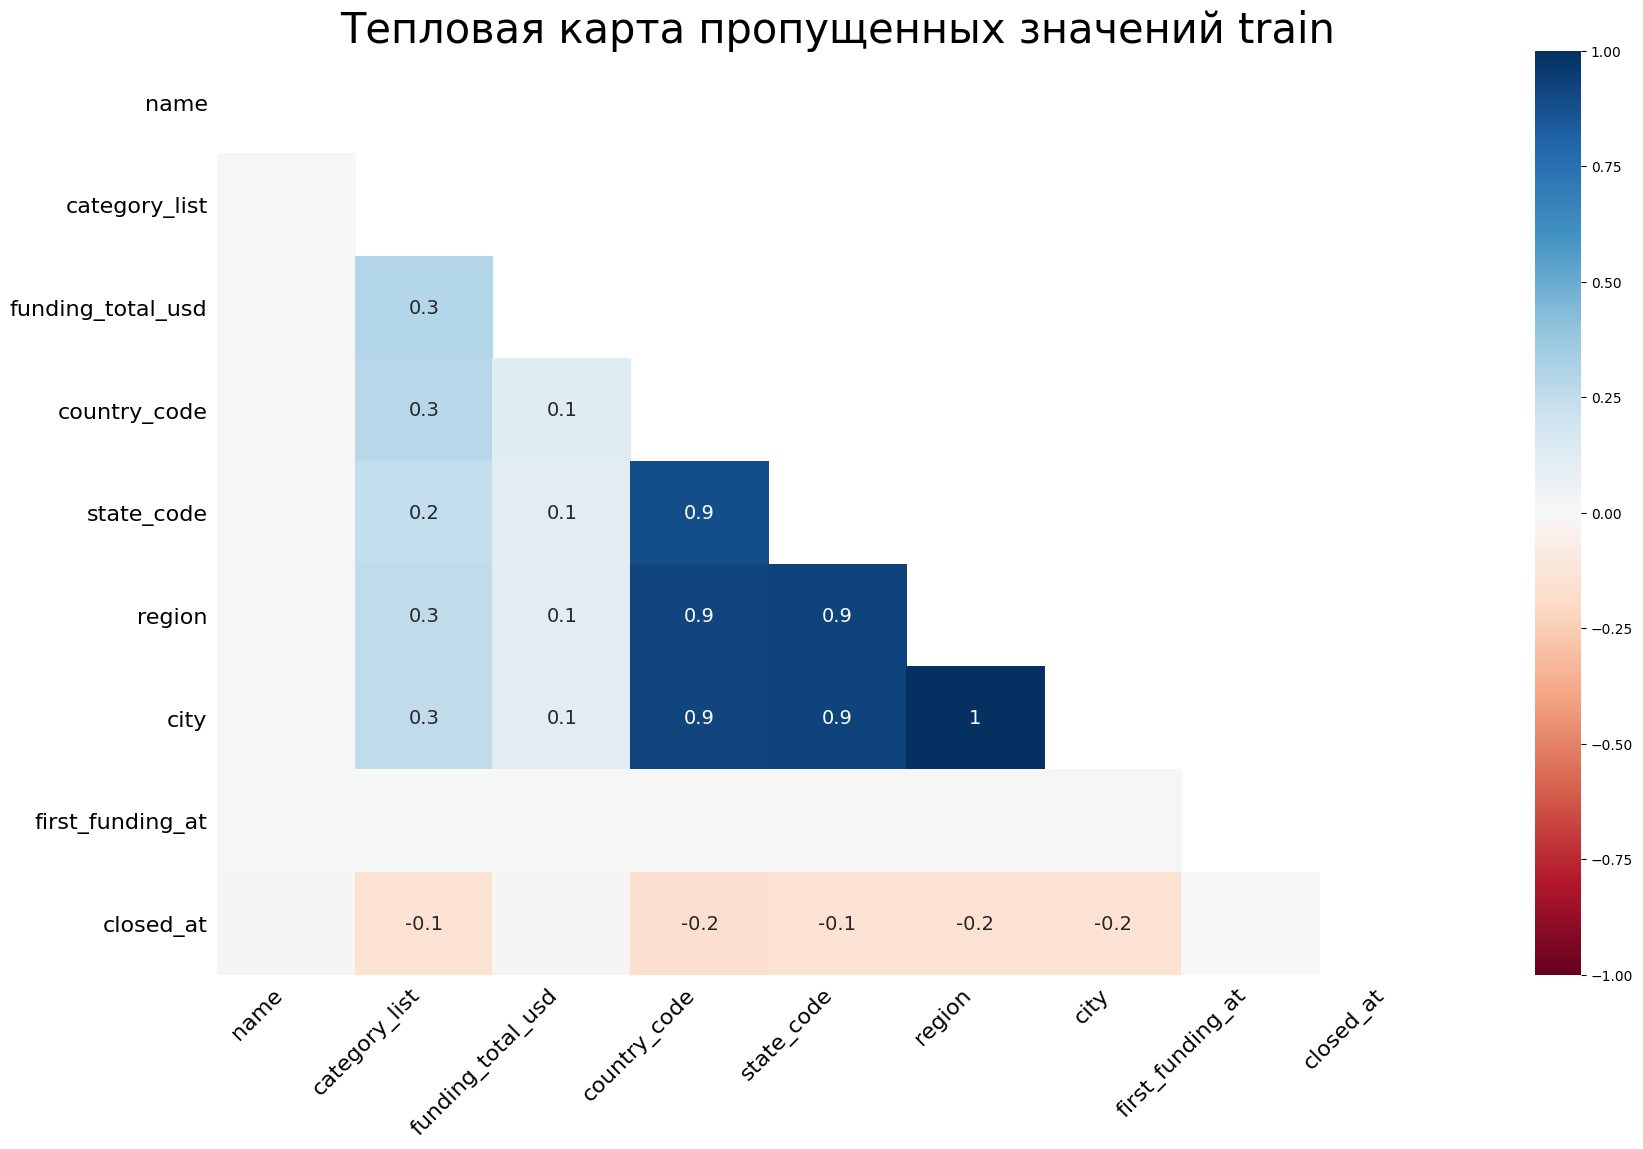

name                     1
category_list         2505
funding_total_usd    10126
status                   0
country_code          5528
state_code            6797
region                6390
city                  6390
funding_rounds           0
founded_at               0
first_funding_at        21
last_funding_at          0
closed_at            47917
dtype: int64

Датафрейм: test


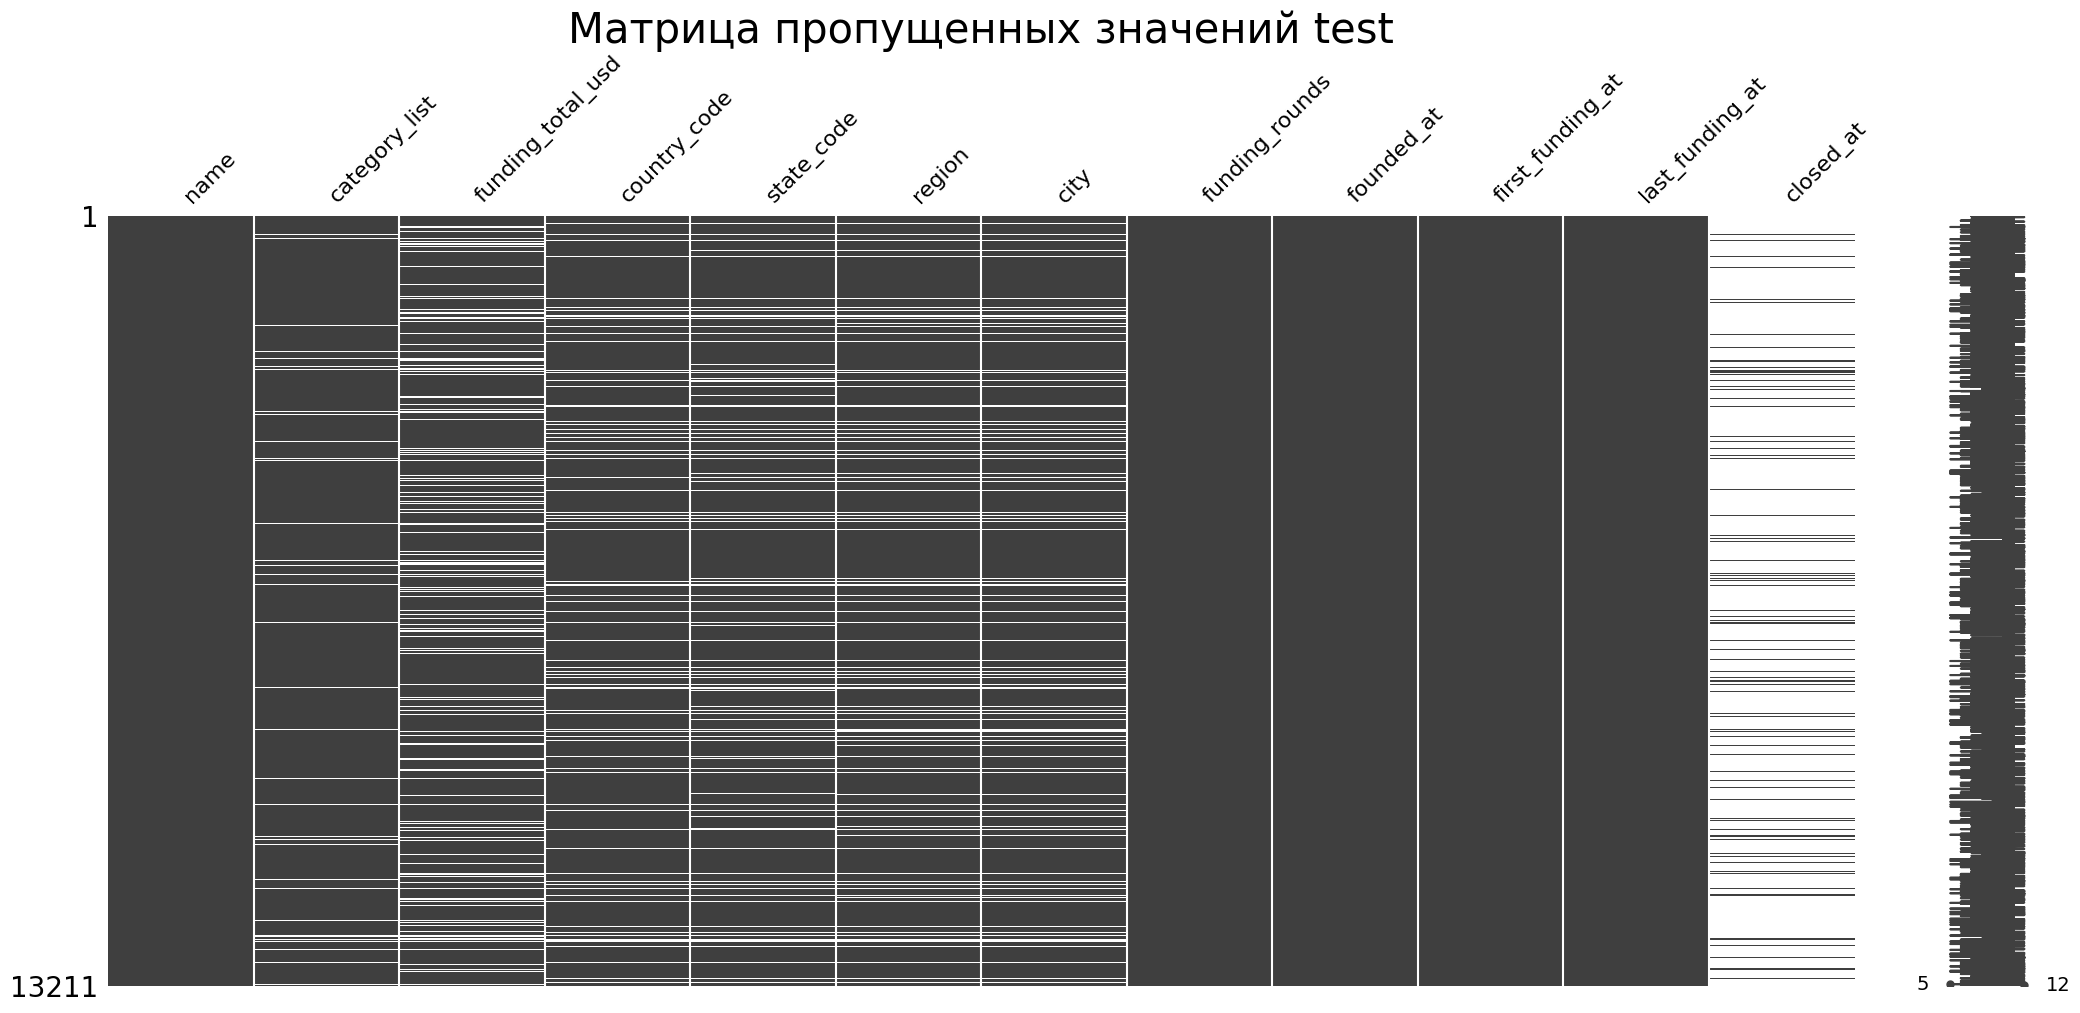

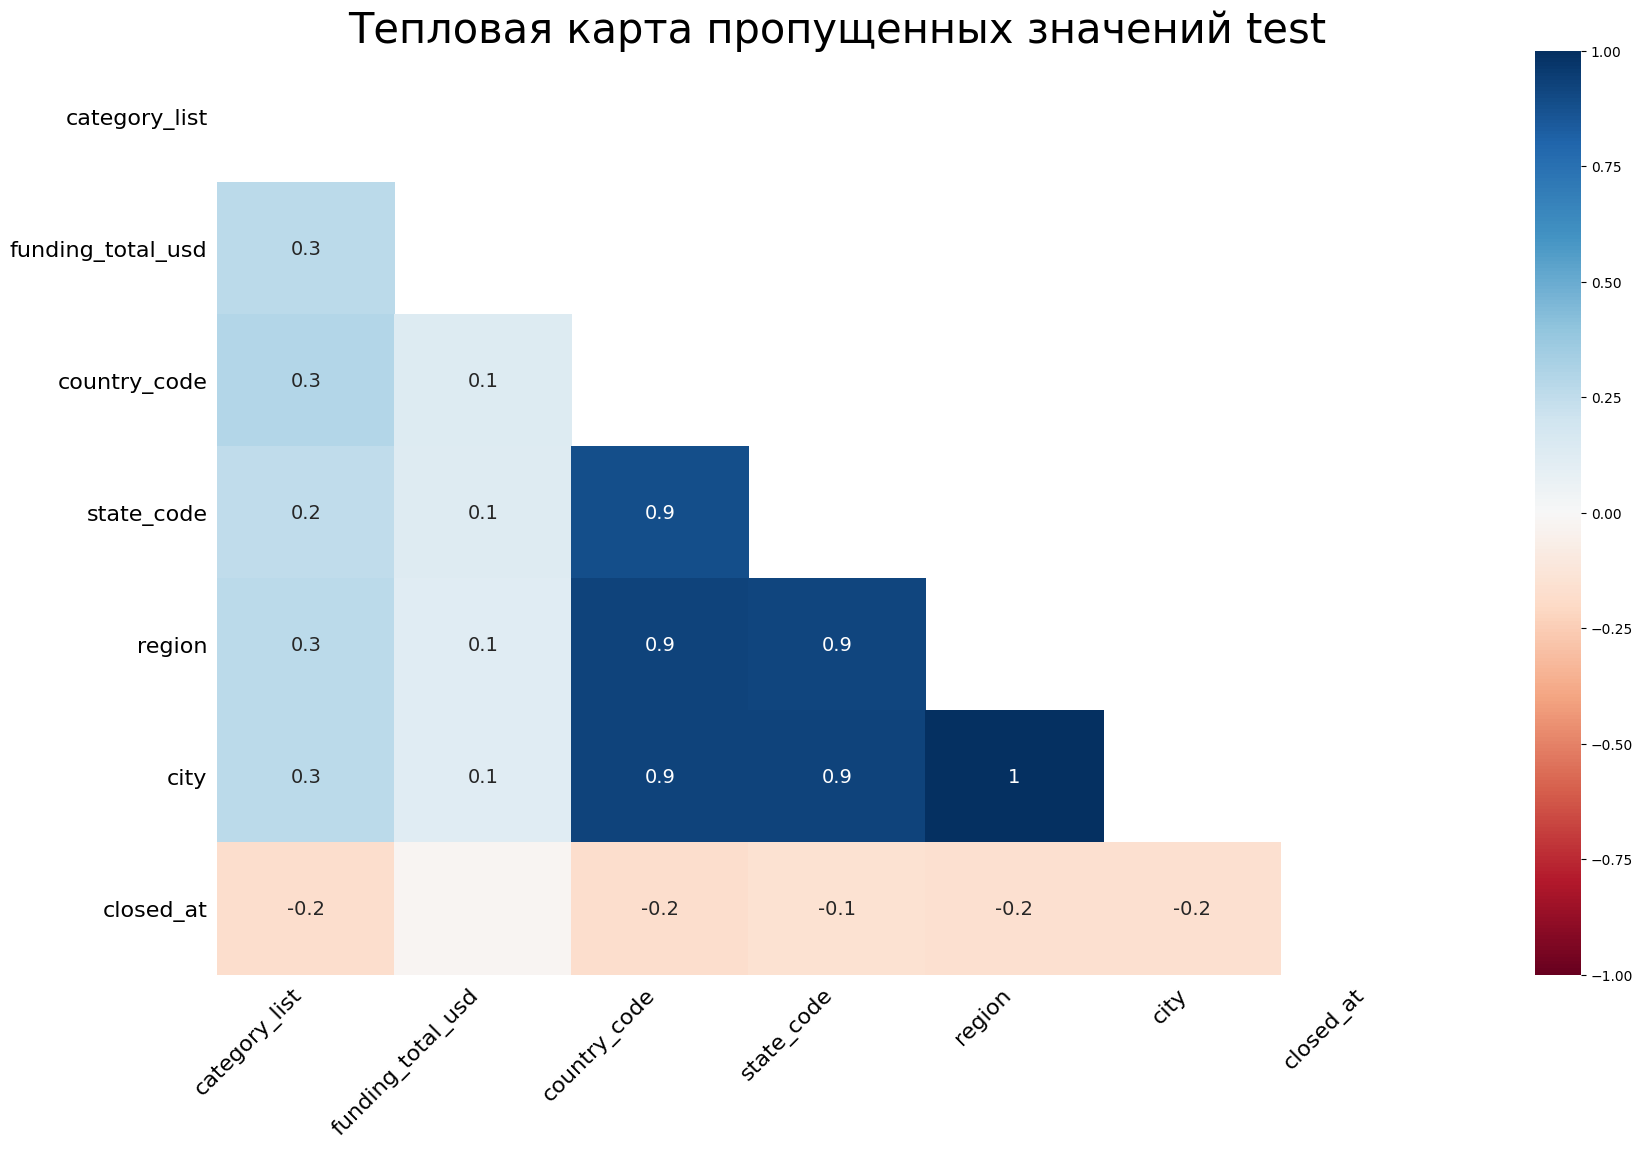

name                     0
category_list          601
funding_total_usd     2595
country_code          1384
state_code            1699
region                1593
city                  1591
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            11977
dtype: int64


In [10]:
for name, df in dataframes.items():
    print('\nДатафрейм:',name);
    msno.matrix(df);
    plt.title('Матрица пропущенных значений '+name, fontsize=30)
    msno.heatmap(df);
    plt.title('Тепловая карта пропущенных значений '+name, fontsize=30)
    plt.show()
    print(df.isnull().sum())
    

Для следующих полей необходимо проанализировать способы устранения пропущенных значений:
- `category_list`;
- `funding_total_usd`;
- `country_code`;
- `state_code`;
- `region`;
- `city`;
- `first_funding_at`;
- `closed_at`.

Также стоит отметить высокую корреляцию пропущенных значений для полей, содержащих данные об адресе стартапа.

    

#### `сategory_list`

В данном случае речь идет о категориальных данных. Поэтому наиболее подходящий метод в данном случае - это заполнение модой, то есть метод заполнения наиболее часто встречающимся значением.

In [11]:
# Создадим объект класса SimpleImputer с параметром strategy = 'most_frequent'
imp_most_freq = SimpleImputer(strategy = 'most_frequent')
for name, df in dataframes.items():
    df['category_list'] = imp_most_freq.fit_transform(df[['category_list']])
    # Убедимся, что пропусков не осталось
    print('Количество пропусков для столбца category_list датафрейма '+name, df.category_list.isna().sum())

Количество пропусков для столбца category_list датафрейма train 0
Количество пропусков для столбца category_list датафрейма test 0


#### `funding_total_usd`

Это количественный признак, используем медианные значения для заполнения пропусков.

In [12]:
# Создадим объект класса SimpleImputer с параметром strategy = 'median'
imp_median = SimpleImputer(strategy = 'median')
for name, df in dataframes.items():
    df['funding_total_usd'] = imp_median.fit_transform(df[['funding_total_usd']])
    # Убедимся, что пропусков не осталось
    print('Количество пропусков для столбца funding_total_usd датафрейма '+name, df.funding_total_usd.isna().sum())

Количество пропусков для столбца funding_total_usd датафрейма train 0
Количество пропусков для столбца funding_total_usd датафрейма test 0


#### `country_code`, `state_code`, `region`, `city`

Используем метод заполнения наиболее часто встречающимся значением, так как данные являются категориальными.

In [13]:
for name, df in dataframes.items():
    df['country_code'] = imp_most_freq.fit_transform(df[['country_code']])
    df['state_code'] = imp_most_freq.fit_transform(df[['state_code']])
    df['region'] = imp_most_freq.fit_transform(df[['region']])
    df['city'] = imp_most_freq.fit_transform(df[['city']])
    # Убедимся, что пропусков не осталось
    print('\nКоличество пропусков для столбца country_code датафрейма '+name, df.country_code.isna().sum())
    print('Количество пропусков для столбца state_code датафрейма '+name, df.state_code.isna().sum())
    print('Количество пропусков для столбца region датафрейма '+name, df.region.isna().sum())
    print('Количество пропусков для столбца city датафрейма '+name, df.city.isna().sum())


Количество пропусков для столбца country_code датафрейма train 0
Количество пропусков для столбца state_code датафрейма train 0
Количество пропусков для столбца region датафрейма train 0
Количество пропусков для столбца city датафрейма train 0

Количество пропусков для столбца country_code датафрейма test 0
Количество пропусков для столбца state_code датафрейма test 0
Количество пропусков для столбца region датафрейма test 0
Количество пропусков для столбца city датафрейма test 0


#### `first_funding_at`

Для пропущенных значений используем дату основания стартапа.

In [14]:
df_train['first_funding_at'] = df_train['first_funding_at']. fillna(df_train['founded_at'])
print('Количество пропусков для столбца first_funding_at датафрейма train', df_train.first_funding_at.isna().sum())

Количество пропусков для столбца first_funding_at датафрейма train 0


#### `closed_at`

Проверим ситуацию, когда поле пустое, а стартап уже закрыт.

In [15]:
for name, df in dataframes.items():
    print(df_train.query('closed_at == "" & status == "closed"'))

Empty DataFrame
Columns: [name, category_list, funding_total_usd, status, country_code, state_code, region, city, funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at]
Index: []
Empty DataFrame
Columns: [name, category_list, funding_total_usd, status, country_code, state_code, region, city, funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at]
Index: []


Подобные значения не найдены.

### Обработка неявных дубликатов

Первичное знакомство с данными показало отсутствие явных дубликатов. Проверим наличие неявных дубликатов среди категориальных данных.

Сформируем список столбцов с категориальными данными.

In [34]:
category_fields_list = ['country_code', 'state_code', 'region', 'city']

Приведем данные к единому регистру и уберем пробелы в начале и конце строк.

In [18]:
for name, df in dataframes.items():
    print('\nДатафрейм', name)
    for field in category_fields_list:
        print('\nКоличество уникальных значений для поля '+field, df[field].nunique())
        df[field] = df[field].str.lower()
        df[field] = df[field].str.strip()
        print('Количество уникальных значений после обработки для поля '+field, df[field].nunique())


Датафрейм train

Количество уникальных значений для поля category_list 22196
Количество уникальных значений после обработки для поля category_list 22196

Количество уникальных значений для поля country_code 134
Количество уникальных значений после обработки для поля country_code 134

Количество уникальных значений для поля state_code 300
Количество уникальных значений после обработки для поля state_code 300

Количество уникальных значений для поля region 1037
Количество уникальных значений после обработки для поля region 1037

Количество уникальных значений для поля city 4524
Количество уникальных значений после обработки для поля city 4524

Датафрейм test

Количество уникальных значений для поля category_list 6220
Количество уникальных значений после обработки для поля category_list 6220

Количество уникальных значений для поля country_code 96
Количество уникальных значений после обработки для поля country_code 96

Количество уникальных значений для поля state_code 235
Количество уни

In [22]:
df_train.count()

name                 52878
category_list        52879
funding_total_usd    52879
status               52879
country_code         52879
state_code           52879
region               52879
city                 52879
funding_rounds       52879
founded_at           52879
first_funding_at     52879
last_funding_at      52879
closed_at             4962
dtype: int64

In [39]:
for name, df in dataframes.items():
    print('\nДатафрейм', name)
    for field in category_fields_list:
        print('\nСтолбец', field) 
        list_to_check = df[field].unique()
        i = 0
        for i in range(0, len(list_to_check)):
            for j in range(i+1, len(list_to_check)):
                score = fuzz.token_sort_ratio(list_to_check[i], list_to_check[j])
                if score > 94 and score < 100:
                    print(list_to_check[i]+'<--->'+list_to_check[j],i,j)           


Датафрейм train

Столбец country_code

Столбец state_code

Столбец region
montpelier<--->montpellier 120 468

Столбец city
charlestown<--->charleston 88 221
charlestown<--->charles town 88 4228
pittsburgh<--->pittsburg 127 2281
surry hills<--->surrey hills 252 2831
silver spring<--->silver springs 436 3526
collingwood<--->collingswood 562 3126
arlington<--->darlington 740 3940
bet shemesh<--->beit-shemesh 818 3778
forest hills<--->forest hill 1015 2128
woodbridge<--->woodridge 1043 1384
ekaterinburg<--->yekaterinburg 1231 1633
george town<--->georgetown 1252 1653
ponte vedra<--->pontevedra 1314 4474
middletown<--->middleton 1373 1648
tewkesbury<--->tewksbury 1539 2232
morgantown<--->morganton 1621 3717
farmington<--->farington 1780 3246
wadsworth<--->wandsworth 1799 2278
belo horizonte<--->bello horizonte 2025 2305
river falls<--->fall river 2135 4172
beavercreek<--->beaver creek 2435 3075
granville<--->grandville 2559 3043

Датафрейм test

Столбец country_code

Столбец state_code

Ст